In [49]:
import time
import copy
import numpy as np
from skimage.filters import gaussian
import cv2

import matplotlib.pyplot as plt
import pylab as pl

%matplotlib inline
%pylab inline
pylab.rcParams['figure.figsize'] = (15, 10)

from tifffile import imread, imsave
import cPickle as pickle

%reload_ext autoreload
%autoreload 2

from netsurface2d import NetSurf2d
from netsurface2dt import NetSurf2dt
from data3d import Data3d
import bresenham as bham

Populating the interactive namespace from numpy and matplotlib


In [87]:
folder = '/Users/jug/Repositories/GIT/BobSeg/export/'
flow = imread(folder+'flow.tiff')
stack = imread(folder+'stack.tiff')

segchannel = stack[:,1,:,:]
flowchannel = stack[:,0,:,:]
sigma = [0.,2.,2.]
segchannel_smooth = gaussian(segchannel,sigma)

flow_x = np.swapaxes(flow,0,1)[0]
flow_y = np.swapaxes(flow,0,1)[1]

print shape(stack)
assert shape(stack) == shape(flow)

(20, 2, 542, 919)


In [123]:
line_x1 = 200
line_y1 = 200
line_x2 = 350
line_y2 = 350
line = (line_x1,line_y1,line_x2,line_y2)
line_length = math.sqrt( (line_x1-line_x2)**2 + (line_y1-line_y2)**2)
print 'line length: '+str(line_length)
line_pixels = bham.bresenhamline(np.array([(line_x1,line_y1)]),np.array([(line_x2,line_y2)]))
print 'bresenham line length: '+str(len(line_pixels))

line length: 212.132034356
bresenham line length: 150


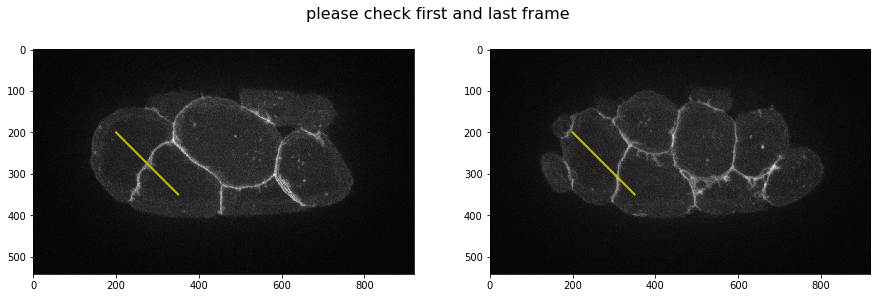

In [124]:
pylab.rcParams['figure.figsize'] = (15, 4.5)
fig = plt.figure()
fig.suptitle('please check first and last frame', fontsize=16)
ax = fig.add_subplot(121)
ax.imshow(segchannel[0], plt.get_cmap('gray'))
ax.plot([line_x1,line_x2],[line_y1,line_y2],'y-',lw=2)
ax = fig.add_subplot(122)
ax.imshow(segchannel[-1], plt.get_cmap('gray'))
ax.plot([line_x1,line_x2],[line_y1,line_y2],'y-',lw=2)

In [131]:
def get_projected_length(line,flow_x,flow_y):
    ldx = line[0]-line[2]
    ldy = line[1]-line[3]
    len_line = math.sqrt(ldx**2+ldy**2)
    return (flow_x*ldx + flow_y*ldy)/len_line

def get_pixel_values(image, coords):
    values = []
    for c in coords:
        values.append(image[c[1]][c[0]])
    return values

In [142]:
kymo_intensity = np.zeros((len(line_pixels),len(stack)))
kymo_projflow = np.zeros((len(line_pixels),len(stack)))
for col in range(len(stack)):
    fx = get_pixel_values(flow_x[col], line_pixels)
    fy = get_pixel_values(flow_y[col], line_pixels)
    for row in range(len(line_pixels)):
        x = line_pixels[row][0]
        y = line_pixels[row][1]
        kymo_intensity[row,col] = segchannel[col,y,x]
        kymo_projflow[row,col] = get_projected_length(line,fy[row],fx[row])

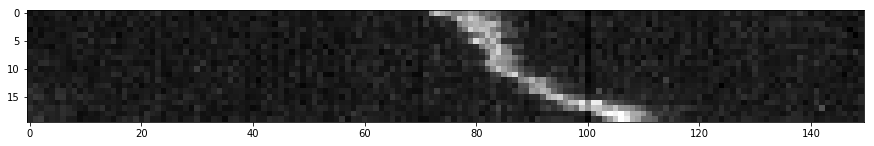

In [143]:
imshow(kymo_intensity.T, plt.get_cmap('gray'))

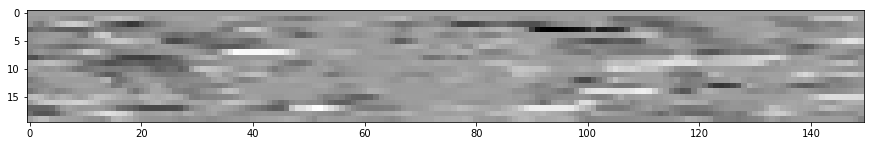

In [134]:
imshow(kymo_projflow.T, plt.get_cmap('gray'))

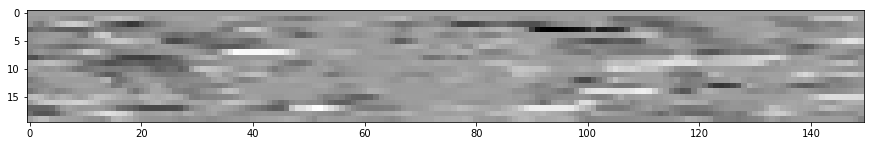

In [144]:
imshow(kymo_projflow.T, plt.get_cmap('gray'))